<a href="https://colab.research.google.com/github/iamscj/CatDogDetectionWithVariousModels/blob/main/CatDogDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Neural Network



In this notebook you will learn to distinguish dogs from cats!

Data:
https://drive.google.com/drive/folders/1bkcr55sW6BrcgKVPEGTb3vvhpnrklKKq?usp=sharing

Fill in cells below and fit neural networks for solving the binary classification task.

**Requirement**
- Python, Pytorch (Must), and all other necessary libraries
- **Just don't cheat, Thanks!**
- Sample output is to help you understand the task, and get an idea of what you have to do
- Dur date is Nov 10, 11:59pm. You ONLY need to submit this notebook. Include instructions to run your code.

## Task 1(25 points):

1. Build and fit CNN with 3 convolutional layers for binary classification
2. Evaluate accuracy on test data
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)

First, let's load all the necessary functions:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Research on how to load google drive files into colab if you are using colab

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/test-20230725T062948Z-001.zip' ./
!cp '/content/drive/MyDrive/Colab Notebooks/train-20230725T062949Z-001.zip' ./
!cp '/content/drive/MyDrive/Colab Notebooks/val-20230725T062951Z-001.zip' ./

In [ ]:
!unzip /content/test-20230725T062948Z-001.zip

In [ ]:
!unzip /content/train-20230725T062949Z-001.zip


In [ ]:
!unzip /content/val-20230725T062951Z-001.zip

In [ ]:
!ls train/dogs/ | wc -l

10000


The images collected for training and testing the deep learning model must be prepared: split the entire set into a training, validation and test sample, observing the balancing of classes (with binary classification they should be approximately equal in all three samples).

This has _already_ been done: in the Cats_and_Dogs directory there are three subdirectories: train, test and val - training, test and validation samples, respectively.

In [ ]:
# Initialize the folders with train, test and validation datasets (in "/My Drive/..." or from your local repository where you have downloaded data):

train = 'train'
val = 'val'
test = 'test'

# The shape of the RGB image
img_width, img_height, channels = 150, 150, 3 # you can try different sizes

# input shape
input_shape = (img_width, img_height, 3)
# position matters!
# Number_of_channels can be at the first or the last position
# in our case - "channels last"

# minibatch size
batch_size = 4
# train set size
nb_train_samples = 20000
# validation set size
nb_validation_samples = 2490
# test set size
nb_test_samples = 2500

## Prepare the data.

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

resize = transforms.Resize(size=(img_height, img_width))
trainTransforms = transforms.Compose([resize, transforms.ToTensor()])
testTransforms = transforms.Compose([resize, transforms.ToTensor()])

train_path = '/content/train/'
test_path = '/content/test/'

train_data = ImageFolder(train_path, transform=trainTransforms)
test_data = ImageFolder(test_path, transform=testTransforms)
# Setup the batch size hyperparameter
BATCH_SIZE = batch_size

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7cee2d557a60>, <torch.utils.data.dataloader.DataLoader object at 0x7cee2d557640>)
Length of train dataloader: 5000 batches of 4
Length of test dataloader: 625 batches of 4


Set the network architecture by sequentially adding layers to it:
1. A convolutional layer with 16 neurons, filter size 3x3. Activation function - 'relu'
2. MaxPooling layer with filter size 2x2.
3. A convolutional layer with 32 neurons, filter size 3x3. Activation function - 'relu'
4. MaxPooling layer with filter size 2x2.
5. A convolutional layer with 64 neurons, filter size 3x3. Activation function - 'relu'
6. MaxPooling layer with filter size 2x2.
7. flatten, which makes a one-dimensional vector of the resulting feature maps.
8. A fully connected layer with 64 neurons. Activation function - 'relu'
9. Use Dropout (0.5) which excludes the edge from the current layer in the computational graph with a 50% probability to avoid overfitting.
10. A fully connected layer with 1 neuron. Activation function - 'sigmoid', because binary classification model.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch


class CatsVsDogsModel(nn.Module):
    def __init__(self):
        super(CatsVsDogsModel, self).__init__()

        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc_model = nn.Sequential(
            nn.Linear(64 * 17 * 17, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
import torch.optim as optim
from torch.autograd import Variable

model = CatsVsDogsModel()
model = model.cuda()

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0
    count = 0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(inputs)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # print(inputs)
        print(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # TODO: calculate the preds
        preds =
        loss = criterion(outputs.float(), labels.float())
        print(preds.float())
        print(labels)
        print(loss)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        count += len(preds)
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] accuracy: {running_corrects / count:.3f}')
            running_counts = 0
            running_loss = 0.0
            count = 0


Epoch 1/15


C:\Users\Eva_D\AppData\Local\Temp\ipykernel_14748\1973074310.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_15=model_1.fit_generator(


312/312 [==============================] - 61s 194ms/step - loss: 0.0382 - accuracy: 0.9842 - val_loss: 0.7919 - val_accuracy: 0.8520
Epoch 2/15
312/312 [==============================] - 59s 189ms/step - loss: 0.0400 - accuracy: 0.9840 - val_loss: 0.9584 - val_accuracy: 0.8450
Epoch 3/15
312/312 [==============================] - 60s 191ms/step - loss: 0.0344 - accuracy: 0.9857 - val_loss: 0.8898 - val_accuracy: 0.8586
Epoch 4/15
312/312 [==============================] - 60s 191ms/step - loss: 0.0377 - accuracy: 0.9853 - val_loss: 0.8993 - val_accuracy: 0.8532
Epoch 5/15
312/312 [==============================] - 59s 190ms/step - loss: 0.0422 - accuracy: 0.9839 - val_loss: 0.8974 - val_accuracy: 0.8495
Epoch 6/15
312/312 [==============================] - 60s 192ms/step - loss: 0.0364 - accuracy: 0.9858 - val_loss: 1.0431 - val_accuracy: 0.8405
Epoch 7/15
312/312 [==============================] - 60s 193ms/step - loss: 0.0358 - accuracy: 0.9856 - val_loss: 0.9996 - val_accuracy: 0.8

In [ ]:
# NOTE: if the accuracy on test data after 15 epochs is less than 80% smth goes wrong


C:\Users\Eva_D\AppData\Local\Temp\ipykernel_14748\3264715676.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model_1.evaluate_generator(test_generator, nb_test_samples // batch_size)


Accuracy on test data: 85.58%


Plot the graphs:

- Loss(Number of epochs)

- Accuracy(Number of epochs)

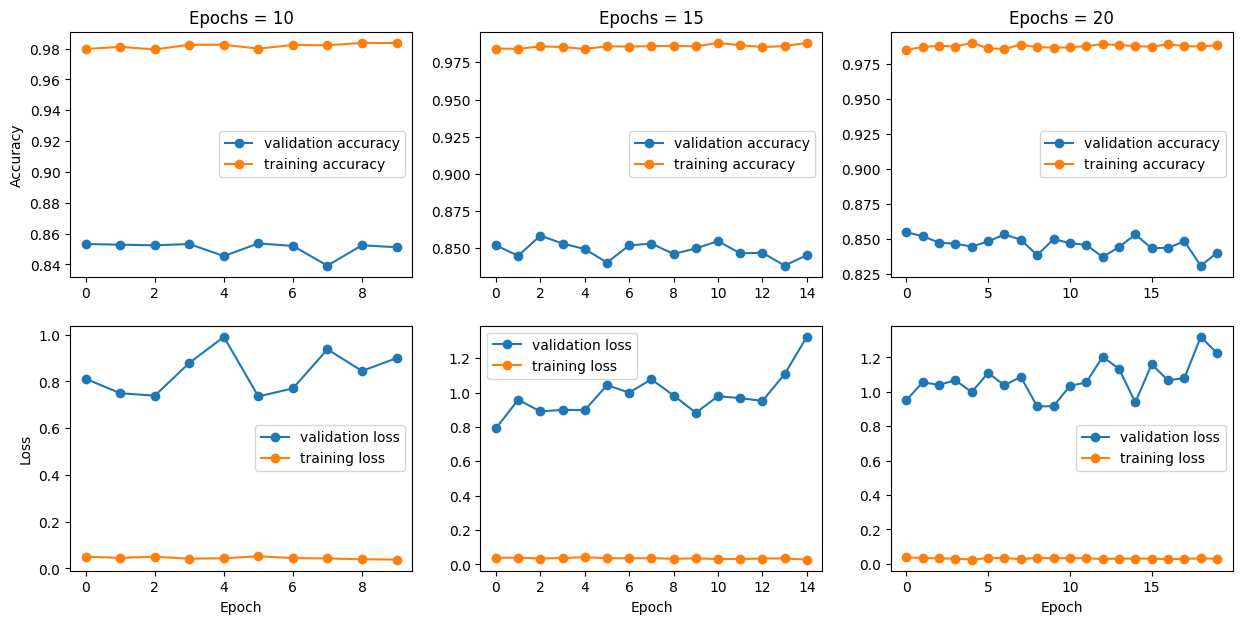

Let's try to improve the quality of recognition, using the method of transfer lerning.

We will use weights of deep neural networks already trained on large dataset such as  ImageNet, and provide fine tuning of several additional dense layers on new data relevant to the current classification task. The more new images will differ from those on which the network has been trained, the more layers will need to be “retrained” in order to get good classification accuracy. The intuition here is that the model has already learned how to highlight the necessary features on the images in the large dataset, it only needs to be “tweaked” for a specific task.

## Task 2(25 points)

1. Build and fit Transfer Learning model using pre-trained VGG16-model weights.
2. Evaluate accuracy on test data for p.1 and p.2
3. Plot the graphs for Loss(number_of_epochs) and Accuracy(number_of_epochs)
4. Check the performance of your model with the custom image of cat or dog (so the model will tell which class this image belongs to). Develop the function for the inference of the best algorithm.

In [ ]:
# First, download the weights of the VGG16 network trained on the ImageNet dataset:

import tensorflow as tf

vgg16_model = tf.keras.applications.VGG16(
    include_top=False,  # Exclude the top classification layers
    weights='imagenet',  # Load pre-trained weights from ImageNet
    input_shape=(224, 224, 3)  # Adjust input shape as needed
)

# Summary of the VGG16 model to view its architecture
vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

We construct our model of "transfer learning" by adding two fully connected layers to VGG16

In [ ]:
# add layers to VGG16:
from tensorflow import keras

# Create a Sequential model
transfer_model = keras.Sequential()

# Add the pre-trained VGG16 model (excluding top classification layers)
transfer_model.add(vgg16_model)  # Assuming 'vgg16_model' is your pre-trained VGG16 model

# Flatten the output from VGG16 to connect with fully connected layers
transfer_model.add(keras.layers.Flatten())

# Add custom fully connected layers
transfer_model.add(keras.layers.Dense(256, activation='relu'))
transfer_model.add(keras.layers.Dropout(0.5))  # Optional dropout layer for regularization
transfer_model.add(keras.layers.Dense(2, activation='softmax'))  # 2 output units for binary classification

# Summary of the transfer learning model
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 21137986 (80.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Implement the code to train the model
# Without using a GPU, learning 1 epoch of such a network will take about an hour. Plan your time =)
# If you have access to a GPU, you can try 10-12 epochs - the quality should increase even more.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_dir = '/content/drive/MyDrive/Cats_and_Dogs/train'
batch_size = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for data loading and rescaling
train_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only normalize pixel values

# Create a data generator for training data without augmentation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),  # Adjust the target size as needed
    batch_size=batch_size,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)


# # Create an ImageDataGenerator for data augmentation and preprocessing
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255.0,  # Normalize pixel values
#     rotation_range=20,  # Randomly rotate images
#     width_shift_range=0.2,  # Randomly shift images horizontally
#     height_shift_range=0.2,  # Randomly shift images vertically
#     shear_range=0.2,  # Shear intensity
#     zoom_range=0.2,  # Randomly zoom images
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest'  # Fill mode for data augmentation
# )

Found 20000 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

# Define the load_and_build_model function
def load_and_build_model():
    # Load the pre-trained VGG16 model
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the convolutional base (optional)
    for layer in vgg16_model.layers:
        layer.trainable = False

    # Add custom layers on top of the VGG16 model
    x = Flatten()(vgg16_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(2, activation='softmax')(x)  # 2 output units for binary classification

    # Create the custom model
    custom_model = Model(inputs=vgg16_model.input, outputs=x)

    # Compile the custom model
    custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return custom_model

In [ ]:
model = load_and_build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
validation_data_dir = '/content/drive/MyDrive/Cats_and_Dogs/val'

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2490 images belonging to 2 classes.


In [ ]:
# Train the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=12,  # Adjust the number of epochs
    validation_data=validation_generator
)

Epoch 1/12
625/625 [==============================] - 3645s 6s/step - loss: 0.2805 - accuracy: 0.8971 - val_loss: 0.2928 - val_accuracy: 0.8815
Epoch 2/12
625/625 [==============================] - 93s 149ms/step - loss: 0.1303 - accuracy: 0.9477 - val_loss: 0.1777 - val_accuracy: 0.9345
Epoch 3/12
625/625 [==============================] - 91s 145ms/step - loss: 0.1001 - accuracy: 0.9603 - val_loss: 0.2642 - val_accuracy: 0.9088
Epoch 4/12
625/625 [==============================] - 91s 145ms/step - loss: 0.0894 - accuracy: 0.9641 - val_loss: 0.2733 - val_accuracy: 0.9060
Epoch 5/12
625/625 [==============================] - 92s 147ms/step - loss: 0.0731 - accuracy: 0.9706 - val_loss: 0.2268 - val_accuracy: 0.9309
Epoch 6/12
625/625 [==============================] - 91s 146ms/step - loss: 0.0482 - accuracy: 0.9814 - val_loss: 0.2956 - val_accuracy: 0.9120
Epoch 7/12
625/625 [==============================] - 91s 145ms/step - loss: 0.0330 - accuracy: 0.9879 - val_loss: 0.3233 - val_acc

# Save and Showcase how good is your model

In [ ]:
# Define the path to your test dataset
test_data_dir = '/content/drive/MyDrive/Cats_and_Dogs/test'

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create a data generator for test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model on test data
test_results = model.evaluate(test_generator)

# Display the test accuracy
test_accuracy = test_results[1]
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

Found 2500 images belonging to 2 classes.
79/79 [==============================] - 12s 146ms/step - loss: 0.4044 - accuracy: 0.9100
Test accuracy: 91.00%


In [ ]:
print(history.history)

{'loss': [0.28054726123809814, 0.1303427666425705, 0.10010284185409546, 0.08944050967693329, 0.07313519716262817, 0.04816444590687752, 0.033029358834028244, 0.04076700657606125, 0.0360095240175724, 0.01842145062983036, 0.021411823108792305, 0.03174511343240738], 'accuracy': [0.8970999717712402, 0.9476500153541565, 0.9602500200271606, 0.9641000032424927, 0.9706000089645386, 0.9814000129699707, 0.9879000186920166, 0.9837499856948853, 0.9851499795913696, 0.9938499927520752, 0.9925500154495239, 0.9886000156402588], 'val_loss': [0.29284578561782837, 0.1777123361825943, 0.2642297148704529, 0.2732838988304138, 0.22680343687534332, 0.2956463694572449, 0.3232795298099518, 0.35230764746665955, 0.3473303020000458, 0.3603413999080658, 0.4027908742427826, 0.4060310125350952], 'val_accuracy': [0.8815261125564575, 0.9345381259918213, 0.9088353514671326, 0.9060240983963013, 0.9309237003326416, 0.9120482206344604, 0.9216867685317993, 0.924096405506134, 0.9244980216026306, 0.9228915572166443, 0.92449802

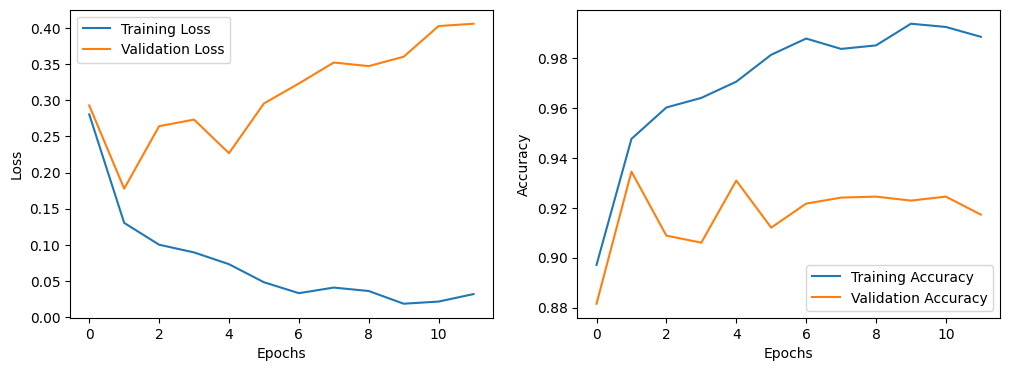

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation loss and accuracy from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot the loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/cat_dog_model_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 735ms/step


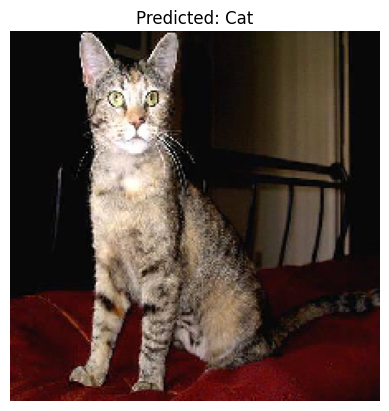

The image is a Cat.
1/1 [==============================] - 0s 132ms/step


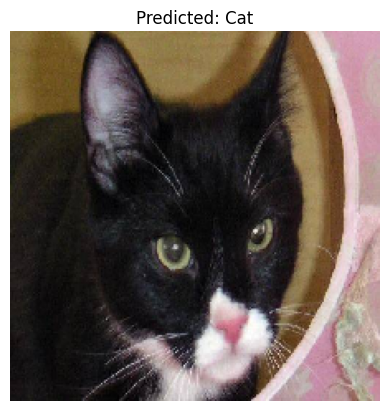

The image is a Cat.
1/1 [==============================] - 0s 204ms/step


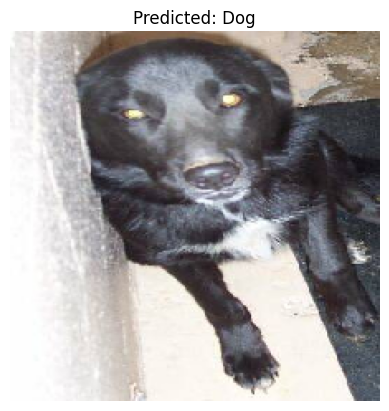

The image is a Dog.


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

def preprocess_custom_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = img[np.newaxis, ...]
    return img

def predict_image_class(image_path, model_path):
    model = tf.keras.models.load_model(model_path)

    img = preprocess_custom_image(image_path)
    prediction = model.predict(img)
    if prediction[0][0] > prediction[0][1]:
        class_label = "Cat"
    else:
        class_label = "Dog"

    # Load and display the image
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_label}")
    plt.show()

    return class_label

image_paths = [
    '/content/drive/MyDrive/Cats_and_Dogs/test/cats/cat.10000.jpg',
    '/content/drive/MyDrive/Cats_and_Dogs/test/cats/cat.10001.jpg',
    '/content/drive/MyDrive/Cats_and_Dogs/test/dogs/dog.10000.jpg'
    # Add more image paths here if needed
]

model_path = '/content/drive/MyDrive/cat_dog_model_2.h5'

for image_path in image_paths:
    result = predict_image_class(image_path, model_path)
    print(f"The image is a {result}.")

[link text](https://)In this task, we will create and train a ResNet-based model from scratch to improve classification accuracy.

## Task 3(25 points)
Build and Train ResNet-based Model:

Design a ResNet-based neural network architecture, customizing the number of layers, channels, and other hyperparameters based on classification task.

Plot Loss and Accuracy

Evaluate accuracy on validation and test datasets separately.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your training dataset
train_data_dir = '/content/drive/MyDrive/Cats_and_Dogs/train'
input_shape = (224, 224, 3)  # Adjust the input shape to match your model

# Set the number of classes (cats and dogs)
num_classes = 2

# Set the number of residual blocks and number of filters in each block
num_blocks = 4
num_filters = 64


def basic_residual_block(x, filters, stride=1):
    # Shortcut branch
    shortcut = x

    # Main branch
    x = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding="same")(x)
    x = BatchNormalization()(x)

    # Adjust dimensions of shortcut to match the main branch
    if stride > 1:
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the main branch
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

def build_resnet(input_shape, num_classes, num_blocks, num_filters, block_type="basic"):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(num_filters, kernel_size=(7, 7), padding="same", strides=2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=2)(x)

    for block in range(num_blocks):
        stride = 1 if block == 0 else 2
        if block_type == "basic":
            x = basic_residual_block(x, num_filters, stride)

    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model

# Build the ResNet model
model = build_resnet(input_shape, num_classes, num_blocks, num_filters, block_type="basic")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 64)         0         ['batch_normalization[0]

In [ ]:
# Data augmentation for training (you can customize these settings)
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1
)

# Create a data generator for training data
batch_size = 32  # You can adjust this as needed
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=True
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10  # Adjust the number of epochs as needed
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs
)

# Save the trained model
model.save('/content/drive/MyDrive/resnet_model.h5')

Found 20000 images belonging to 2 classes.
Epoch 1/10
625/625 [==============================] - 318s 496ms/step - loss: 0.6388 - accuracy: 0.6326
Epoch 2/10
625/625 [==============================] - 301s 481ms/step - loss: 0.5707 - accuracy: 0.6995
Epoch 3/10
625/625 [==============================] - 301s 482ms/step - loss: 0.5114 - accuracy: 0.7473
Epoch 4/10
625/625 [==============================] - 300s 480ms/step - loss: 0.4506 - accuracy: 0.7869
Epoch 5/10
625/625 [==============================] - 302s 483ms/step - loss: 0.3857 - accuracy: 0.8255
Epoch 6/10
625/625 [==============================] - 302s 483ms/step - loss: 0.3346 - accuracy: 0.8558
Epoch 7/10
625/625 [==============================] - 310s 496ms/step - loss: 0.2935 - accuracy: 0.8740
Epoch 8/10
625/625 [==============================] - 308s 492ms/step - loss: 0.2687 - accuracy: 0.8860
Epoch 9/10
625/625 [==============================] - 302s 483ms/step - loss: 0.2450 - accuracy: 0.8973
Epoch 10/10
625/625 [

In [ ]:
 # Test the accuracy
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load the trained model
resnet_loaded_model = load_model('/content/drive/MyDrive/resnet_model.h5')

test_data_dir = '/content/drive/MyDrive/Cats_and_Dogs/test'

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

batch_size = 32  # You can adjust this as needed
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # Disable shuffling for evaluation
)

Found 2500 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = resnet_loaded_model.evaluate(test_generator, verbose=1)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

79/79 [==============================] - 9s 111ms/step - loss: 0.2682 - accuracy: 0.8828
Test Accuracy: 88.28%


1/1 [==============================] - 0s 227ms/step


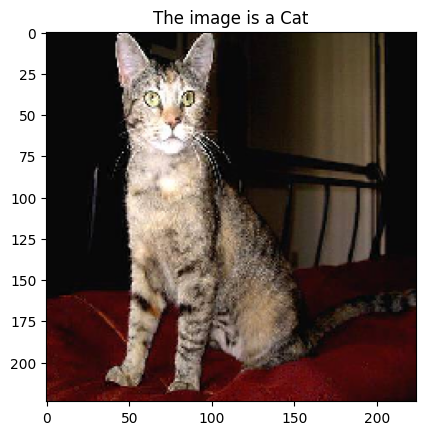

1/1 [==============================] - 0s 22ms/step


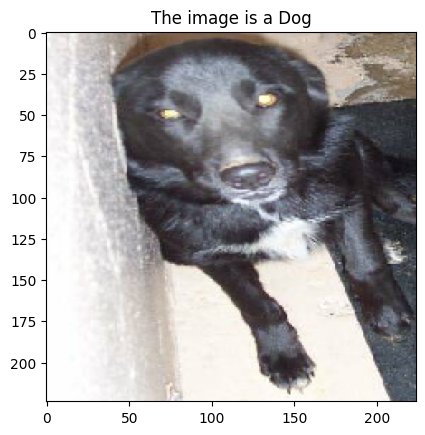

1/1 [==============================] - 0s 22ms/step


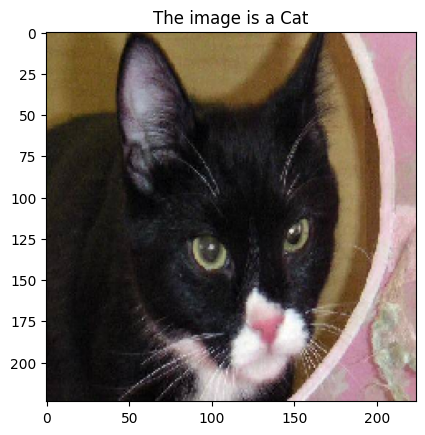

1/1 [==============================] - 0s 22ms/step


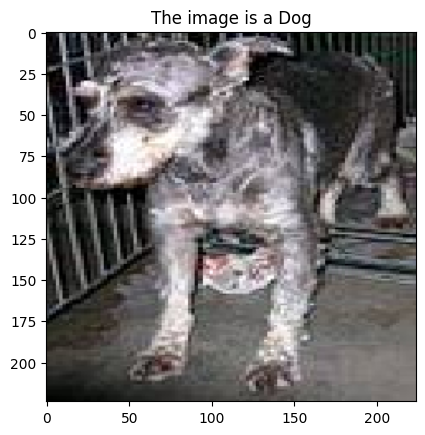

In [ ]:
# Evaluate the model on the test data
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Load the trained model
resnet_loaded_model = load_model('/content/drive/MyDrive/resnet_model.h5')

# Directory containing test images
test_data_dir = '/content/drive/MyDrive/Cats_and_Dogs/test'

# List of image file names (you can replace these with actual file names)
image_files = [
    'cats/cat.10000.jpg',
    'dogs/dog.10000.jpg',
    'cats/cat.10001.jpg',
    'dogs/dog.10001.jpg'
]

# Define a function to preprocess and predict the class for an image
def predict_image_class(image_path, model):
    # Load and preprocess the image
    img = image.load_img(os.path.join(test_data_dir, image_path), target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image

    # Make a prediction
    prediction = model.predict(img)

    # Get the class label (assuming binary classification)
    class_label = "Cat" if prediction[0][0] > 0.5 else "Dog"

    # Display the image
    plt.figure()
    plt.imshow(img[0])
    plt.title(f"The image is a {class_label}")
    plt.show()

# Evaluate the model on example images
for image_file in image_files:
    predict_image_class(image_file, resnet_loaded_model)

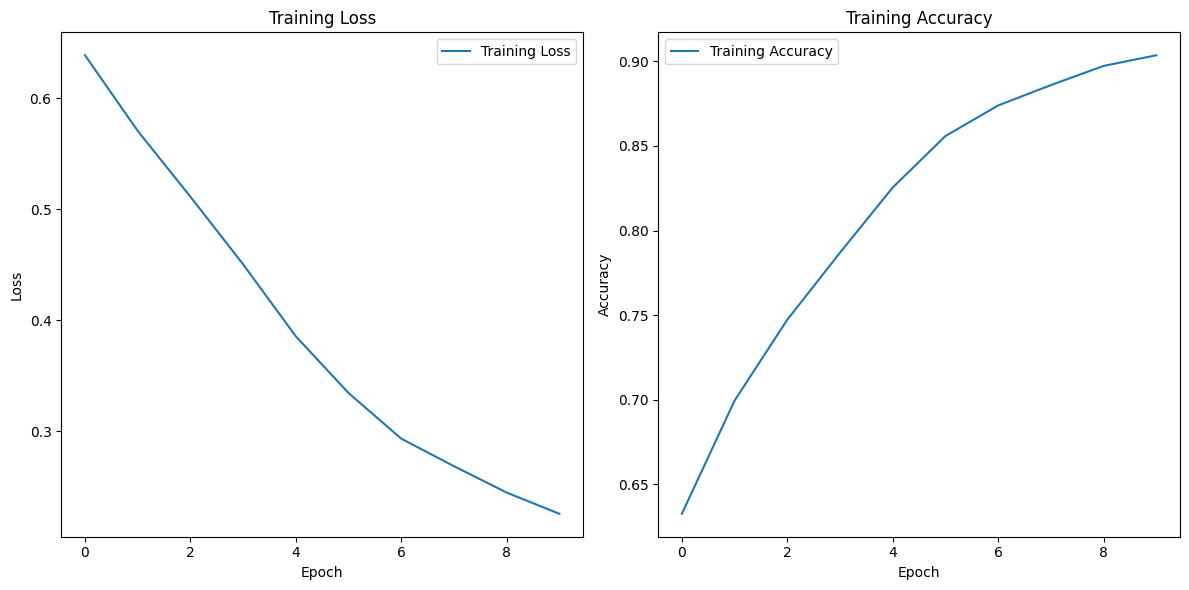

In [ ]:
# Plot loss and accuracy
import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In this task, we will create and train a UNet-based model from scratch to improve classification accuracy.

## Task 4(25 points)
Build and Train UNet-based Model for binary classification task:

Design a UNet-based neural network architecture, customizing the encoder,bottleneck, and the decoder structure.

Plot Loss and Accuracy

Evaluate accuracy on test datasets.

In [ ]:
import torch
import torch.nn as nn

# Define the basic building blocks: Encoder Block,Bottleneck Block, Decoder Block

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):

    def forward(self, x):

class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels):

    def forward(self, x):

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):

    def forward(self, x, bridge):

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Encoder
        self.encoder =

        # Bottleneck
        self.bottleneck =

        # Decoder
        self.decoder =

    def forward(self, x):


# Create a U-Net model for binary classification
unet = UNet()

# Define Binary Cross-Entropy loss and an optimizer
criterion =
optimizer =


AttributeError: ignored

Found 20000 images belonging to 2 classes.


NameError: ignored

In [ ]:
#Define the model training process

#Plot Loss and Accuracy

#Evaluate accuracy on test datasets.